In [4]:
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [5]:
import seaborn as sns
import scienceplots

In [6]:
plt.style.use('science')
plt.rcParams['figure.figsize'] = [2*3.54, 2*3.54]
dpi = 300  # Increased DPI for better quality
plt.rcParams['savefig.dpi'] = dpi
plt.rcParams['figure.dpi'] = 100  # Keep display DPI reasonable
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [7]:
import plotting as pltt

In [15]:
bbbbbox = dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='gray', linewidth=0.5)

def plot_box(ax, xmin, xmax, ymin, ymax, zmin, zmax, color, alpha=1, label=None, zorder=None):
    # Draw a rectangular box (RPP)
    x = [xmin, xmax]
    y = [ymin, ymax]
    z = [zmin, zmax]# Draw edges
    for s, e in [
        # bottom
        ([x[0], y[0], z[0]], [x[1], y[0], z[0]]),
        ([x[1], y[0], z[0]], [x[1], y[1], z[0]]),
        ([x[1], y[1], z[0]], [x[0], y[1], z[0]]),
        ([x[0], y[1], z[0]], [x[0], y[0], z[0]]),
        # top
        ([x[0], y[0], z[1]], [x[1], y[0], z[1]]),
        ([x[1], y[0], z[1]], [x[1], y[1], z[1]]),
        ([x[1], y[1], z[1]], [x[0], y[1], z[1]]),
        ([x[0], y[1], z[1]], [x[0], y[0], z[1]]),
        # sides
        ([x[0], y[0], z[0]], [x[0], y[0], z[1]]),
        ([x[1], y[0], z[0]], [x[1], y[0], z[1]]),
        ([x[1], y[1], z[0]], [x[1], y[1], z[1]]),
        ([x[0], y[1], z[0]], [x[0], y[1], z[1]])
    ]:
        ax.plot3D(*zip(s, e), color=color, alpha=alpha, zorder=zorder, linewidth=1.2)
    # Draw faces
    faces = [
        # bottom
        [[x[0], y[0], z[0]], [x[1], y[0], z[0]], [x[1], y[1], z[0]], [x[0], y[1], z[0]]],
        # top
        [[x[0], y[0], z[1]], [x[1], y[0], z[1]], [x[1], y[1], z[1]], [x[0], y[1], z[1]]],
        # front
        [[x[0], y[0], z[0]], [x[1], y[0], z[0]], [x[1], y[0], z[1]], [x[0], y[0], z[1]]],
        # back
        [[x[0], y[1], z[0]], [x[1], y[1], z[0]], [x[1], y[1], z[1]], [x[0], y[1], z[1]]],
        # left
        [[x[0], y[0], z[0]], [x[0], y[1], z[0]], [x[0], y[1], z[1]], [x[0], y[0], z[1]]],
        # right
        [[x[1], y[0], z[0]], [x[1], y[1], z[0]], [x[1], y[1], z[1]], [x[1], y[0], z[1]]]
    ]
    poly3d = Poly3DCollection(faces, facecolors=color, alpha=alpha, zorder=zorder, linewidths=0.5, edgecolors='k')
    ax.add_collection3d(poly3d)
    if label:
        ax.text((xmin+xmax)/2, (ymin+ymax)/2, (zmin+zmax)/2, label, color='black', zorder=(zorder or 1)+1, bbox=bbbbbox, fontsize=10, ha='center', fontweight='bold')


def plot_cylinder(ax, base, vec, radius, height, color, alpha=1, label=None, zorder=None):
    # Draw a cylinder (RCC) with flat ends
    x0, y0, z0 = base
    dx, dy, dz = vec
    # Normalize direction vector
    length = np.sqrt(dx**2 + dy**2 + dz**2)
    if length == 0:
        return
    dx, dy, dz = dx/length, dy/length, dz/length
    # Create cylinder along z, then rotate
    z = np.linspace(0, height, 30)
    theta = np.linspace(0, 2*np.pi, 30)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    # Build rotation matrix
    v = np.array([dx, dy, dz])
    v0 = np.array([0, 0, 1])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
        xyz_rot = R @ xyz
        x_grid = xyz_rot[0].reshape(x_grid.shape)
        y_grid = xyz_rot[1].reshape(y_grid.shape)
        z_grid = xyz_rot[2].reshape(z_grid.shape)
    x_grid += x0
    y_grid += y0
    z_grid += z0
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=alpha, linewidth=0, shade=True)

    # Flat ends
    for zc in [0, height]:
        # Circle in xy-plane
        x_end = radius * np.cos(theta)
        y_end = radius * np.sin(theta)
        z_end = np.full_like(x_end, zc)
        # Rotate
        xyz_end = np.stack([x_end, y_end, z_end])
        if not np.allclose(v, v0):
            xyz_end = R @ xyz_end
        x_end = xyz_end[0] + x0
        y_end = xyz_end[1] + y0
        z_end = xyz_end[2] + z0
        # Use Poly3DCollection for flat ends
        verts = [list(zip(x_end, y_end, z_end))]
        poly = Poly3DCollection(verts, facecolors=color, alpha=alpha, zorder=zorder)
        ax.add_collection3d(poly)

    if label:
        ax.text(x0+radius+2, y0, z0, label, color='black', bbox=bbbbbox, fontsize=10, ha='left', fontweight='bold')

def plot_cone(ax, pos, vec, dir, length, color='red', alpha=1, label=None, zorder=None):
    """
    Draw a cone with end point at pos, pointing in direction vec, with angle from dir
    """
    x0, y0, z0 = pos
    dx, dy, dz = vec
    # Normalize direction vector
    norm = np.sqrt(dx**2 + dy**2 + dz**2)
    if norm == 0:
        return
    dx, dy, dz = dx/norm, dy/norm, dz/norm
    # Create cone base circle
    theta = np.linspace(0, 2*np.pi, 30)
    r = length * np.tan(np.radians(dir))
    x_circle = r * np.cos(theta)
    y_circle = r * np.sin(theta)
    z_circle = np.zeros_like(x_circle)
    # Rotate circle to point in direction vec
    v0 = np.array([0, 0, 1])
    v = np.array([dx, dy, dz])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_circle.flatten(), y_circle.flatten(), z_circle.flatten()])
        xyz_rot = R @ xyz
        x_circle = xyz_rot[0].reshape(x_circle.shape)
        y_circle = xyz_rot[1].reshape(y_circle.shape)
        z_circle = xyz_rot[2].reshape(z_circle.shape)
    x_circle += x0 + dx * length
    y_circle += y0 + dy * length
    z_circle += z0 + dz * length
    # Draw cone surface
    for i in range(len(x_circle)):
        ax.plot([x0, x_circle[i]], [y0, y_circle[i]], [z0, z_circle[i]], color=color, alpha=alpha, zorder=zorder, linewidth=0.8)
    if label:
        ax.text(x0+5, y0+5, z0 + dz * length / 2, label, color='black', bbox=bbbbbox, fontsize=10, ha='left', fontweight='bold')
    


def plot_detector_and_emitter(ax):
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')
    
def plot_MCNP(ax, zorder=100000):
    # Define better colors
    detector_color = '#E74C3C'  # Red
    shield_color = '#3498DB'    # Blue
    lead_color = '#1ABC9C'      # Teal
    ba_color = '#2ECC71'        # Green
    al_color = '#9B59B6'        # Purple
    wheel_color = '#F39C12'     # Orange
    fe_color = '#95A5A6'        # Grey

    # Detector (surface 21)
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color=detector_color, alpha=0.9, label='Detector', zorder=zorder-1)
    

    # Shielding boxes (RPPs)
    plot_box(ax, 19, 29, -7.5, 7.5, -11, 9, color=shield_color, alpha=0.8, 
            #  label='PbPE', 
             zorder=zorder)
    plot_box(ax, 9, 19, 4, 9, -11, 9, color=lead_color, alpha=0.7, 
            #  label='Pb', 
             label='Shielding',
             zorder=zorder)
    plot_box(ax, 9, 19, -9, -4, -11, 9, color=lead_color, alpha=0.7, 
             zorder=zorder)
    plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color=lead_color, alpha=0.7, 
             zorder=zorder)
    plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color=lead_color, alpha=0.7, 
             zorder=zorder)
    plot_box(ax, 29, 34, -15, 15, -11, 9, color=lead_color, alpha=0.7, 
             zorder=zorder)
    plot_box(ax, 9, 19, -4, 4, 4, 9, color=lead_color, alpha=0.7, 
             zorder=zorder)
    plot_box(ax, -26, 26, 18, 28, -11, 9, color=ba_color, alpha=0.7, 
            #  label='BA1', 
             zorder=zorder)
    plot_box(ax, -26, 26, -28, -18, -11, 9, color=ba_color, alpha=0.7, 
            #  label='BA2', 
             zorder=zorder)
    plot_box(ax, -65, 65, -28, 28, 10, 10.5, color=al_color, alpha=0.8, 
            #  label='Al', 
             zorder=zorder)
    plot_box(ax, -27, 27, 29, 34, -11, 9, color=fe_color, alpha=0.7, 
            #  label='Fe1', 
             zorder=zorder)
    plot_box(ax, -27, 27, -34, -29, -11, 9, color=fe_color, alpha=0.7, 
            #  label='Fe2', 
             zorder=zorder)

    # Wheels (outer treads only for clarity)
    # plot_cylinder(ax, base=(-2, 77, 8), vec=(0, 25, 0), radius=29, height=25, color=wheel_color, alpha=0.3, label='Wheel 1', zorder=zorder)
    # plot_cylinder(ax, base=(68, 77, 8), vec=(0, 25, 0), radius=29, height=25, color=wheel_color, alpha=0.3, label='Wheel 2', zorder=zorder)
    # plot_cylinder(ax, base=(-2, -77, 8), vec=(0, -25, 0), radius=29, height=25, color=wheel_color, alpha=0.3, label='Wheel 3', zorder=zorder)
    # plot_cylinder(ax, base=(68, -77, 8), vec=(0, -25, 0), radius=29, height=25, color=wheel_color, alpha=0.3, label='Wheel 4', zorder=zorder)

In [13]:
def soil_on_ax(ax):
    """Enhanced soil visualization with better styling"""
    plot_box(ax, -56, 56, -45, 45, 42, 42+30, 
                  color='#8B4513', alpha=0.3, label='Soil', zorder=1)  # Better brown color
    


/tmp/ipykernel_1292763/1095440605.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=-1)


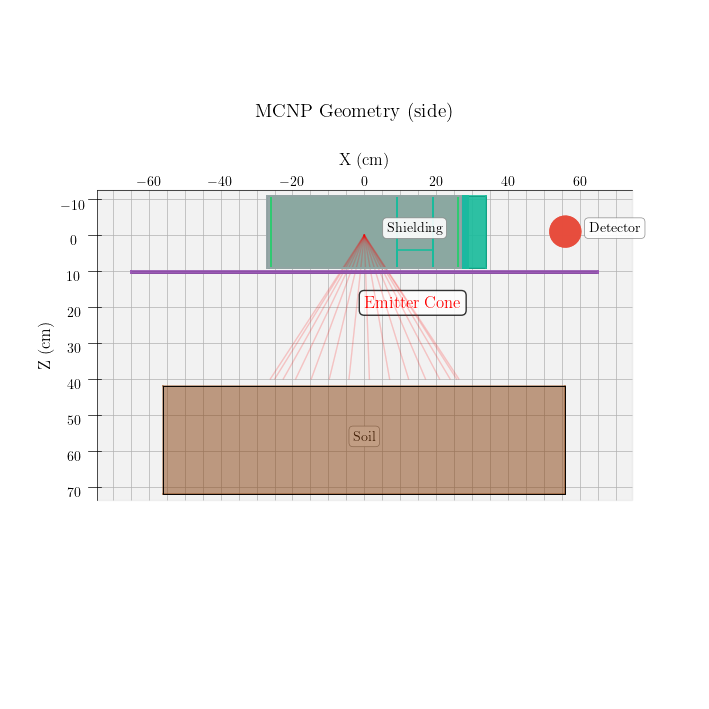

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=[3*3.54, 2*3.54], layout='constrained')
plt.title('MCNP Geometry (side)', y=.9)

plot_MCNP(ax)
pltt.plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.1, label='Emitter Cone', zorder=2000)

soil_on_ax(ax)
pltt.extra(ax)
ax.set_yticklabels([])
ax.set_yticks([]) 
ax.set_ylabel('')
ax.view_init(elev=0, azim=-90,)
ax.set_aspect('equal')
# plt.tight_layout()

plt.savefig('../../Figures/DataGeneration/MCNPGeometry.png', dpi=100, bbox_inches='tight')
plt.show()

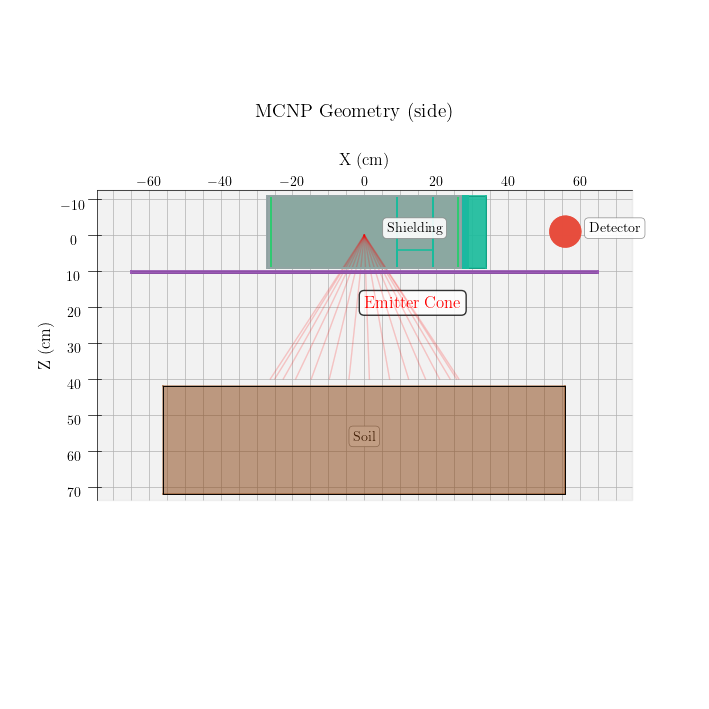

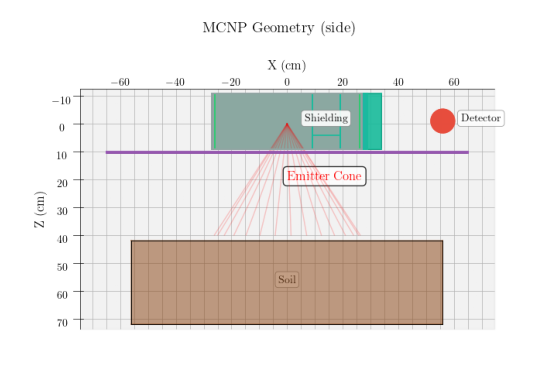

<Figure size 708x708 with 0 Axes>

In [117]:
# load picture
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=[3*3.54, 2*3.54], layout='constrained')
plt.title('MCNP Geometry (side)', y=.9)

plot_MCNP(ax)
pltt.plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.1, label='Emitter Cone', zorder=2000)

soil_on_ax(ax)
pltt.extra(ax)
ax.set_yticklabels([])
ax.set_yticks([]) 
ax.set_ylabel('')
ax.view_init(elev=0, azim=-90,)
ax.set_aspect('equal')
# plt.tight_layout()

plt.savefig('../../Figures/DataGeneration/MCNPGeometry.png', dpi=100, bbox_inches='tight')
# plt.close()


plt.figure()
img = plt.imread('../../Figures/DataGeneration/MCNPGeometry.png')
plt.rcParams['axes.grid'] = False
plt.GridSpec(1, 1)
plt.imshow(img)
plt.axis('off')
# crop top
plt.gca().set_ylim(550, 80)

plt.show()
plt.savefig('../../Figures/DataGeneration/MCNPGeometry.jpg', dpi=100, bbox_inches='tight')

plt.rcParams['axes.grid'] = True


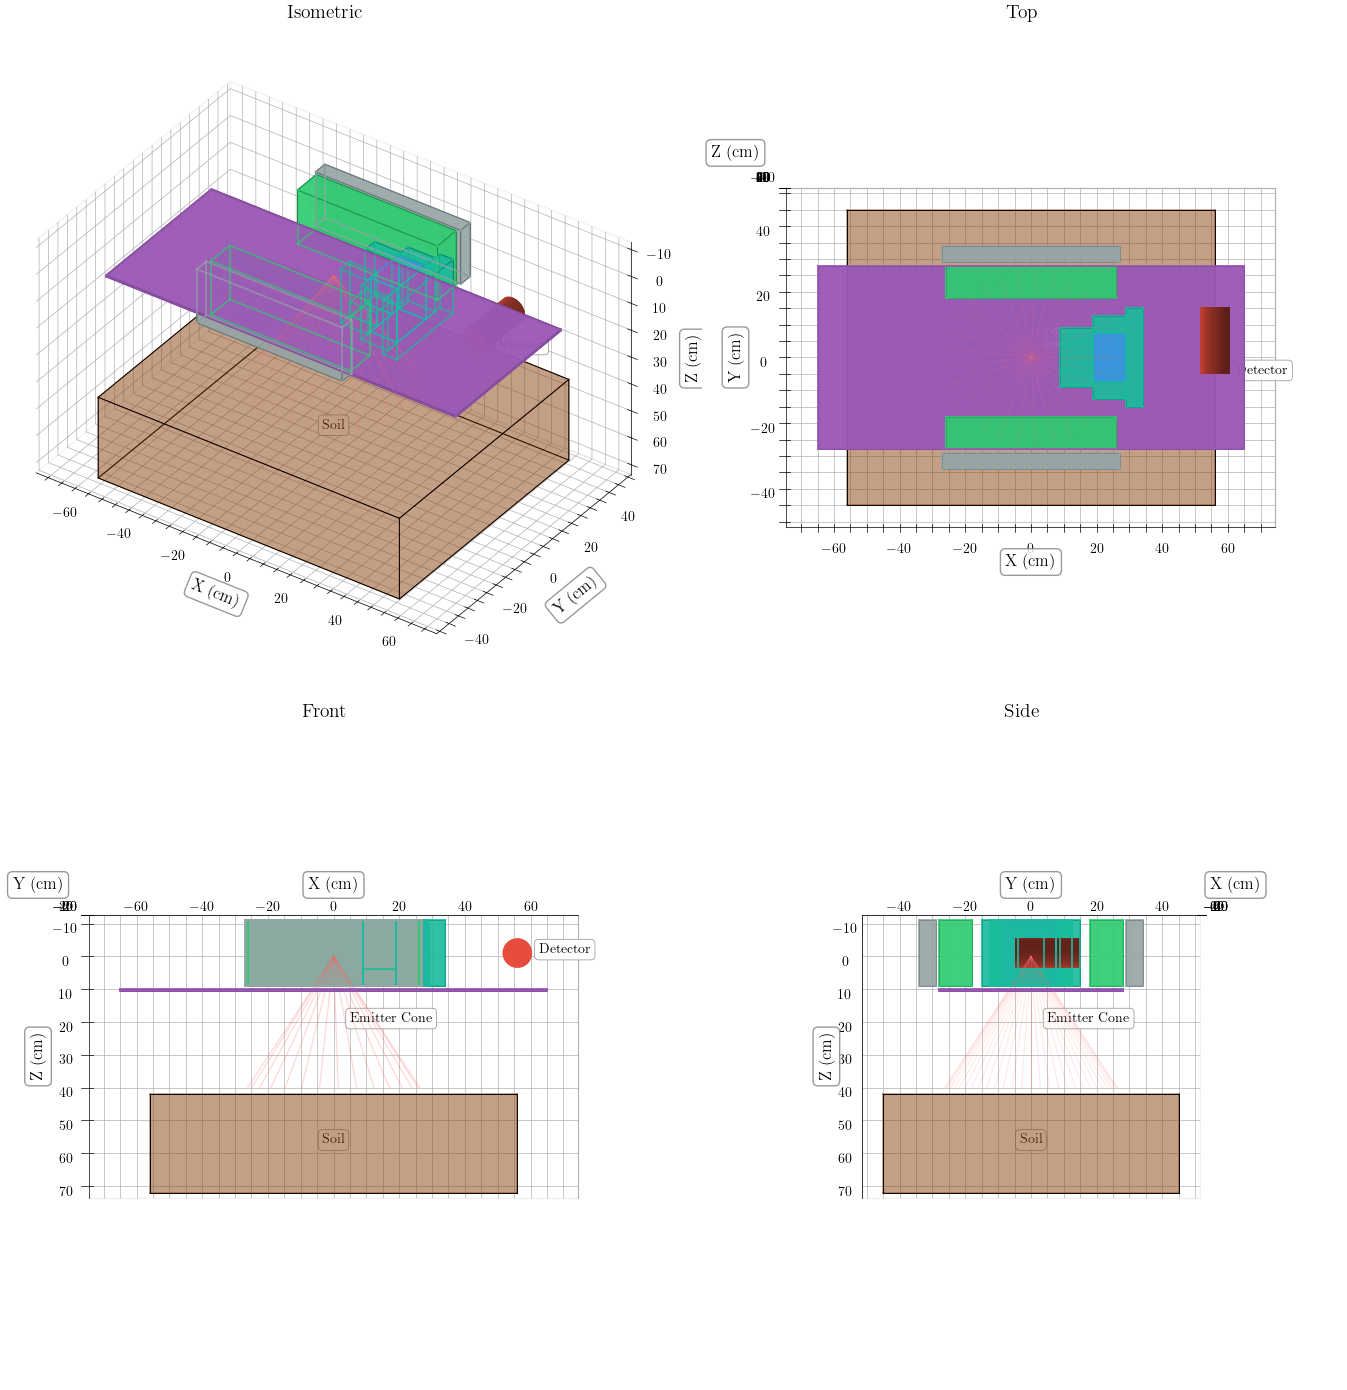

In [11]:
fig = plt.figure(figsize=(2*3.54*2, 2*3.54*2))
views = [
    {'elev': 35, 'azim': -90+35, 'title': 'Isometric'},   # current view
    {'elev': 90, 'azim': -90, 'title': 'Top'},            # top view
    {'elev': 0, 'azim': -90, 'title': 'Front'},           # front view
    {'elev': 0, 'azim': 0, 'title': 'Side'}               # side view
]

axes = []
for i, v in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    plot_MCNP(ax, zorder=100000)
    plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), 
              length=40, color='#FF6B6B', alpha=.15, label='Emitter Cone', zorder=2000)
    soil_on_ax(ax)
    pltt.extra(ax)
    
    # Set title with better styling
    ax.set_title(v['title'], fontsize=14, fontweight='bold', pad=20)
    ax.set_aspect('equal')
    ax.view_init(elev=v['elev'], azim=v['azim'])
    
    # Better axis labels with styled backgrounds
    ax.set_xlabel('X (cm)', fontweight='bold', 
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.8))
    ax.set_ylabel('Y (cm)', fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.8))
    ax.set_zlabel('Z (cm)', fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.8))
    
    # Set consistent axis limits for better comparison
    # ax.set_xlim([-80, 80])
    # ax.set_ylim([-80, 80])
    # ax.set_zlim([-20, 80])
    
    # Improve grid appearance
    ax.grid(True, alpha=0.3)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)
    
    
    ax.set_aspect('equal')

    axes.append(ax)

plt.tight_layout()

plt.savefig('../../Figures/DataGeneration/MCNPGeometry_views.png', dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
ax.set_xlabel('X (cm)', bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.set_ylabel('Y (cm)', bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.set_zlabel('Z (cm)', bbox=dict(facecolor='white', edgecolor='none', pad=2))


Text(-0.05915023405025148, 0.0, 'Z (cm)')

In [ ]:

y0 = 0.0
y1 = 10.0
x0 = 0
x1 = 30


def lineardepth(X):
    z = X[:, 2]
    y = (y1 - y0) / (x1 - x0) * (z - x0) + y0
    return y

In [ ]:
# # 3d plot linear depth
# fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(12, 12))
# # 3d meshgrid
# x = np.linspace(-56, 56, 100)
# y = np.linspace(-45, 45, 100)
# z = np.linspace(0, 30, 100)
# X = np.meshgrid(x, y, z)
# X = np.array(X).reshape(3, -1).T
# # plot linear depth
# ax.scatter(X[:, 0], X[:, 1], 42+30-X[:, 2], c=lineardepth(X), alpha=1, label='Linear Depth', zorder=0)
# # add colorbar
# cbar = plt.colorbar(ax.collections[0], ax=ax, pad=0.1, aspect=10, shrink=0.5)
# cbar.set_label('Carbon Weight', rotation=270, labelpad=20)
# # add percentage symbol to colorbar tick labels
# cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
# cbar.ax.tick_params(labelsize=10)

# pltt.plot_MCNP(ax)
# pltt.plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.1, label='Emitter Cone', zorder=2000)

# soil_on_ax(ax)
# pltt.extra(ax)
# # ax.set_yticklabels([])
# # ax.set_yticks([]) 
# # ax.set_ylabel('')
# ax.view_init(elev=35, azim=-90+35,)
# ax.set_aspect('equal')
# plt.savefig('../../Figures/FunctionallyDefinedSoil/Carbonasafunctioninthesoil.png', dpi=300, bbox_inches='tight')
# plt.show()